In this assignment, you will learn how to use stochastic Langevin Monet Carlo in order to sample from the posterior of a deep network. For the sake of simplicity, we will work with a simple two-layer perceptron architecture:

$$
f(x) = W_2 \text{ReLu}(W_1 x + b_1) + b_2
$$

where $x$ is the (vectorized) input image,  $W_1$ and $W_2$ are weight matrices and $b_1$ and $b_2$ are bias vectors. We use this architecture to learn how to solve a multi-class classification problem with the usual cross-entropy softmax likelihood:

$$
p(y_j \mid W_1, W_2, b_1, b_2, x_j) = \prod_{k=1}^\text{num classes} \rho_k(x_j)^{y_j}
$$

where $y_j$ is the one-hot-encoded training label of the $j$-th image. This is just a categorical distribution over the class labels with probabilities given by our neural network. The model probabilities $\rho_k(x_j)$ are obtained by applying the softmax function to the network outputs:

$$
\rho_k(x_j) = \frac{e^{f_k(x_j)}}{\sum_k^\text{num classes} e^{f_k(x_j)}}
$$

It is easy to see that the softmax transform the uncontraned outputs of the network into a normalized and positive-valued vector that can be interpreted as giving the class probabilities. The loss can be computed by evaluating the negative logarithm of this likelihood and correspond to the usual softmax cross-entropy loss.

We can turn this architecture into a Bayesian neural net by assigning prior distributions to the weights. The simplest op[tion is to use independent Gaussian priors for both weights and biases:

$$
p(W_1) \sim \mathcal{N}(0, I \sigma_{W_1}^2)
$$
$$
p(W_2) \sim \mathcal{N}(0, I \sigma_{W_1}^2)
$$
$$
p(b_1) \sim \mathcal{N}(0, I \sigma_{W_1}^2)
$$
$$
p(b_2) \sim \mathcal{N}(0, I \sigma_{W_1}^2)
$$
We are not bothered by the fact that those variables are respectively matrices and vectors since our Gaussian are assigned independently to each entry. 

In the following code, we use PyTorch to obtain the MAP estimate of the weights by SGD on the fashon MNIST dataset. We start by importing the relevant modules:


In [6]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms

In [7]:
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

We can now import and process the training and validation data.

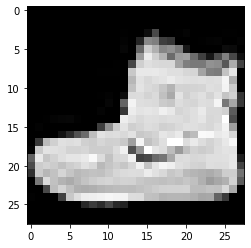

In [11]:
image_length = 28
training_size = len(training_set)
val_size = len(validation_set)

training_dataset = torch.concat([training_set[k][0].view(1,image_length**2) for k in range(training_size)])
training_labels = torch.Tensor([training_set[k][1] for k in range(training_size)]).long()
val_dataset = torch.concat([validation_set[k][0].view(1,image_length**2) for k in range(val_size)])
val_labels = torch.Tensor([validation_set[k][1] for k in range(val_size)]).long()

plt.imshow(training_dataset[0,:].view((image_length,image_length)).detach().numpy(), cmap='gray')
plt.show()

We can now define the two-layer perceptron model in PyTorch. Since our future aim is to do sampling, it is convenient to initialize weights and biases as trainable nn.Parameters instead of initializing the layers directly. In this way, we will not need to extract these variables from the layer. 

In [9]:
# Network forward pass
num_labels = 10

class Network(nn.Module):
    def __init__(self, h_size=100, in_scale = 0.01):
        super(Network, self).__init__()
        # Parameters
        self.h_size = h_size
        self.W1 = nn.Parameter(in_scale*torch.rand((self.h_size, image_length**2)))
        self.b1 = nn.Parameter(in_scale*torch.rand((self.h_size, )))
        self.W2 = nn.Parameter(in_scale*torch.rand((num_labels, self.h_size)))
        self.b2 = nn.Parameter(in_scale*torch.rand((num_labels, )))
        self.params = [self.W1, self.W2, self.b1, self.b2]
        # Prior variances
        self.w1_scale = 1
        self.w2_scale = 1
        self.b1_scale = 1000
        self.b2_scale = 1000

    def forward(self, x):
        x = F.relu(F.linear(x, self.W1, bias=self.b1))
        x = F.linear(x, self.W2, bias=self.b2)
        return x

    def batch_nlog_likelihood(self, x, y):
      loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
      return loss_fn(self.forward(x), y)

    def log_prior(self): # This can be interpreted as a weight decay regularization. High weights are penalize as they could lead to overfitting. 
      w1_prior = - 0.5*torch.sum(self.W1**2)/self.w1_scale**2
      b1_prior = - 0.5*torch.sum(self.b1**2)/self.b1_scale**2
      w2_prior = - 0.5*torch.sum(- self.W2**2)/self.w2_scale**2
      b2_prior = - 0.5*torch.sum(self.b2**2)/self.b2_scale**2
      return w1_prior + b1_prior + w2_prior + b2_prior



We can now write the SGD training loop as usual. 

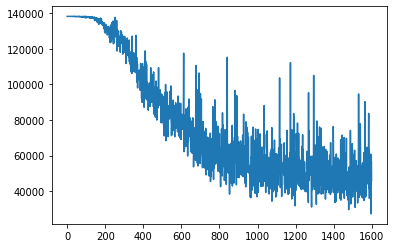

Validation accuracy: 0.7153000235557556


In [10]:
# SGD training
model = Network(h_size=50)
batch_size = 100
num_iters1 = 800
num_iters2 = 800
eta1 = 0.00000001
eta2 = 0.000000001

loss_list = []
for iter in range(num_iters1 + num_iters2):

  #Set optimizer
  if iter < num_iters1:
    optimizer = torch.optim.SGD(model.params, lr=eta1)
  else:
    optimizer = torch.optim.SGD(model.params, lr=eta2)

  # Extract batch
  batch_indices = np.random.choice(range(training_size), size=batch_size, replace=False)
  batch_images = training_dataset[batch_indices,:]
  batch_labels = training_labels[batch_indices]

  # Evaluate loss
  loss = training_size*model.batch_nlog_likelihood(batch_images, batch_labels) - model.log_prior()

  # Compute gradient
  loss.backward()
  loss_list.append(loss.detach().numpy())

  # SGD step
  optimizer.step()

plt.plot(loss_list)
plt.show()

accuracy = torch.mean((model.forward(val_dataset).argmax(1) == val_labels).float())
print("Validation accuracy: {}".format(accuracy))

## Assignment 1

We can now turn our SGD MAP optimizer into a Langevin MCMC sampler. As stated in the lecture, the transition probabilies have the following form:

$$
p(W_\text{new} \mid W_\text{old}) = \mathcal{N}(W_\text{old} - \eta \sum_{j \in \text{minibatch}} \nabla \mathcal{R}_j(W_\text{old}), I \sigma^2)
$$

where $\sum_{j \in \text{minibatch}} \nabla \mathcal{R}_j(W_\text{old})$ is the mini-bacth stochastic gradient estimate that we used in our previous SGD training. 

### Question 1
Write down the formula for the log-acceptance rate of this MCMC method. 

### Question 2
Implement the poposal distribution in PyTorch by modifing the provided SGD code. Hint: you need to extract the gradient from the variables after the .backward() step, add gaissian noise and then perform the update. 

### Question 3
Write PyTorch code to compute the log-acceptance rate given the old and the new proposed sample.

### Question 4
Use the code you wrote in order to implement the M-H corrected Langevin sampler. At each step, you propose a new sample and then use the acceptance rate in order to decide whether to accept it or not. Use the sampler to train the Bayesian neural network on the fashon MNIST dataset. 

Investigate the validation accuracy and probabilistic calibration of the Bayesian classifier when you average the prediction probabilities over all collected posterior samples:

$$
p_k(y_j \mid x_j) = \frac{1}{\text{num samples}}\sum_{W_1,W_2,b_1,b_2 \sim \text{posterior samples}} \rho_k(x_j;W_1,W_2,b_1,b_2)
$$

As you can see, the Bayesian deep network can be seen as an ensemble of classifiers.